# Project: Energy consumption/Load prediction

# Author: Zhassulan Yeshmukhametov

## Introduction
In a world moving towards sustainability, as traditional fuel resources depleting and environmental worries grow, there is a notable shift towards electric solutions. More individuals are opting for electric vehicles (EVs), and countries are actively planning to fully embrace the reliance on EVs for a more sustainable future.


## Problem Statement
Challenges of energy consumption and load prediction in the context of residential electric vehicle (EV) charging in apartment buildings

## Dataset
Data have been collected from a large housing cooperative in Norway, with 1,113 apartments and 2,321 residents. A new infrastructure for EV charging was installed from December 2018. From December 2018 to January 2020, charging sessions were registered by 97 user IDs; 82 of these IDs appeared to be still active at the end of the period. In the data provided with this article, Central European Time (CET) zone is used


### Dataset 1: EV charging reports
The CSV file “Dataset 1” describes 6,878 individual charging sessions, registered by 97 user
IDs from December 2018 to January 2020. The charging reports include plug-in time, plug-out
time and charged energy per charging session. Each charging session is connected to a user
ID, charger ID and address.

### Dataset 2: Hourly EV charging loads and idle capacity, for all sessions and users individually
The CSV file “Dataset 2” describes EV charging loads and non-charging idle capacity for each
user and all EV charging sessions individually. Charging power 3.6 kW or 7.2 kW is assumed, with immediate charging after plug-in. The non-charging idle time reflects the flexibility potential for the charging session. Synthetic idle capacity is the energy load that could potentially have been charged during the idle times.

### Dataset 3 and 4: Hourly EV charging loads and idle capacity, aggregated for private or shared CPs
The CSV files “Dataset 3a” and “Dataset 3b” describe EV charging loads and idle capacity,
aggregated for users with private (3a) or shared (3b) CPs. Charging power 3.6 kW or 7.2 kW
is assumed, with immediate charging after plug-in.

### Dataset 5: Hourly smart meter data from garage Bl2
The CSV file describes hourly smart meter data from garage Bl2, with aggregated electricity use each hour. The EVs were parked in 24 locations, whereof 22 locations have an AMS-meter measuring aggregated EV-charging at that location, with hourly resolution AMS-measurements from a main garage, where 33% of the charging sessions took place (2,243 charging sessions).

### Dataset 6: Local traffic density
Local hourly traffic density in 5 nearby traffic locations. The data includes an hourly count of vehicles shorter than 5.6 meter, from December 2018 to January 2020.

### Dataset 7: Weather Data
Local Weather Data of Trondheim, Norway.The data includes weather features like temperature, rainfall etc from December 2018 to January 2020.

## Import necessary libraries 

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Import necessary libraries  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
from scipy import stats
import seaborn as sns
from scipy.stats import norm 
import statistics 

import warnings
warnings.filterwarnings('ignore')


### Reading Dataset

In [3]:
# Read in the csv to a DataFrame
df_1 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Dataset 1_EV charging reports.csv', sep=';')
df_2 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Dataset 2_Hourly EV loads - Per user.csv', sep=';')
df_3 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Dataset 3a_Hourly EV loads - Aggregated private.csv', sep=';')
df_4 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Dataset 3b_Hourly EV loads - Aggregated shared.csv', sep=';')
df_5 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Dataset 5_AMS data from garage Bl2.csv', sep=';')
df_6 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Dataset 6_Local traffic distribution.csv', sep=';')
df_7 = pd.read_csv('/Users/zhassulan/Desktop/Capstone Project/Norway_Trondheim_ExactLoc_Weather.csv')

### Analyzing the Data
- Let’s start by getting an overview of the dataset and examining its structure
- Then perform EDA for each Dataset separatly and then merge Datasets toghether.

In [4]:
# Print first 5 rows
df_1.head()
df_2.head()
df_3.head()
df_4.head()
df_5.head()
df_6.head()
df_7.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


,date_from,date_to,User_ID,session_ID,Synthetic_3_6kW,Synthetic_7_2kW,Flex_3_6kW,Flex_7_2kW
0,21.12.2018 10:00,21.12.2018 11:00,AdO3-4,1.0,"0,3","0,3",NaN,"0,06"
1,21.12.2018 10:00,21.12.2018 11:00,AdO3-4,2.0,"0,87","0,87",NaN,"0,114"
2,21.12.2018 11:00,21.12.2018 12:00,AdO3-4,3.0,"1,62","3,24",NaN,NaN
3,21.12.2018 12:00,21.12.2018 13:00,AdO3-4,3.0,"3,6","7,2",NaN,NaN
4,21.12.2018 13:00,21.12.2018 14:00,AdO3-4,3.0,"3,6","7,2",NaN,NaN


,date_from,daily_hour,weekday,month,Synthetic_3_6kW,Synthetic_7_2kW,Flex_3_6kW,Flex_7_2kW,n_private
0,21.12.2018 10:00,10,Friday,Dec,"1,17","1,17",0,"0,174",1
1,21.12.2018 11:00,11,Friday,Dec,"1,62","3,24",0,0,1
2,21.12.2018 12:00,12,Friday,Dec,"3,6","7,2",0,0,1
3,21.12.2018 13:00,13,Friday,Dec,"3,6","7,2",0,0,1
4,21.12.2018 14:00,14,Friday,Dec,"3,6","7,2",0,0,1


,date_from,daily_hour,weekday,month,Synthetic_3_6kW,Synthetic_7_2kW,Flex_3_6kW,Flex_7_2kW,n_shared
0,10.01.2019 00:00,0,Thursday,Jan,0,0,0,0,1
1,10.01.2019 01:00,1,Thursday,Jan,0,0,0,0,1
2,10.01.2019 02:00,2,Thursday,Jan,0,0,0,0,1
3,10.01.2019 03:00,3,Thursday,Jan,0,0,0,0,1
4,10.01.2019 04:00,4,Thursday,Jan,0,0,0,0,1


,date_from,date_to,month,AMS_kWh,Synthetic_3_6kW,Synthetic_7_2kW,Simultaneous_if_3_6kW
0,02.01.2019 19:00,02.01.2019 20:00,Jan,"0,05","0,06","0,12",1.0
1,02.01.2019 20:00,02.01.2019 21:00,Jan,"6,6","3,6","7,2",1.0
2,02.01.2019 21:00,02.01.2019 22:00,Jan,"6,8","3,6","7,2",1.0
3,02.01.2019 22:00,02.01.2019 23:00,Jan,"1,45","3,6","0,12",1.0
4,02.01.2019 23:00,03.01.2019 00:00,Jan,"0,05","3,6",0,1.0


,Date_from,Date_to,KROPPAN BRU,MOHOLTLIA,SELSBAKK,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen
0,01.12.2018 00:00,01.12.2018 01:00,639,0,0,4,144
1,01.12.2018 01:00,01.12.2018 02:00,487,153,115,21,83
2,01.12.2018 02:00,01.12.2018 03:00,408,85,75,10,69
3,01.12.2018 03:00,01.12.2018 04:00,282,89,56,8,39
4,01.12.2018 04:00,01.12.2018 05:00,165,64,34,3,25


,Unnamed: 0,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,0,66,2018-12-01,-1.7,5,40,6,34,288,48,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,1,64,2018-12-02,-2.8,5,38,6,33,281,46,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,2,100,2018-12-03,-0.7,5,37,5,33,273,44,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,3,93,2018-12-04,-0.5,5,35,5,32,266,42,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,4,87,2018-12-05,-1.9,5,34,5,32,260,41,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


We can see that each DataFrame has Primary keys and Foreign keys that link data in one table to the data in another table

In [5]:
# Print information about the data:
df_1.info()
df_2.info()
df_3.info()
df_4.info()
df_5.info()
df_6.info()
df_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_ID         6878 non-null   int64  
 1   Garage_ID          6878 non-null   object 
 2   User_ID            6878 non-null   object 
 3   User_type          6878 non-null   object 
 4   Shared_ID          1412 non-null   object 
 5   Start_plugin       6878 non-null   object 
 6   Start_plugin_hour  6878 non-null   int64  
 7   End_plugout        6844 non-null   object 
 8   End_plugout_hour   6844 non-null   float64
 9   El_kWh             6878 non-null   object 
 10  Duration_hours     6844 non-null   object 
 11  month_plugin       6878 non-null   object 
 12  weekdays_plugin    6878 non-null   object 
 13  Plugin_category    6878 non-null   object 
 14  Duration_category  6844 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 806.1+ KB
<class 'pand

After printing information about the data, we see that we have a lot of categorical values that we will need to. And We have NaN values, that need to be checked.

In [6]:
# Checking shape
df_1.shape
df_2.shape
df_3.shape
df_4.shape
df_5.shape
df_6.shape
df_7.shape


(6878, 15)

(88156, 8)

(9757, 9)

(9288, 9)

(9466, 7)

(10248, 7)

(427, 36)

Each DataFrame has different shape. And we need to be careful when we will merge them.

In [7]:
# Checiking for duplicated values
df_1.duplicated().sum()
df_2.duplicated().sum()
df_3.duplicated().sum()
df_4.duplicated().sum()
df_5.duplicated().sum()
df_6.duplicated().sum()
df_7.duplicated().sum()

0

0

0

0

0

0

0

We have no duplicated values

In [8]:
# Looking for null values
df_1.isna().sum()
df_2.isna().sum()
df_3.isna().sum()
df_4.isna().sum()
df_5.isna().sum()
df_6.isna().sum()
df_7.isna().sum()

session_ID              0
Garage_ID               0
User_ID                 0
User_type               0
Shared_ID            5466
Start_plugin            0
Start_plugin_hour       0
End_plugout            34
End_plugout_hour       34
El_kWh                  0
Duration_hours         34
month_plugin            0
weekdays_plugin         0
Plugin_category         0
Duration_category      34
dtype: int64

date_from              0
date_to                0
User_ID              390
session_ID           390
Synthetic_3_6kW    57046
Synthetic_7_2kW    69199
Flex_3_6kW         26070
Flex_7_2kW         15532
dtype: int64

date_from          0
daily_hour         0
weekday            0
month              0
Synthetic_3_6kW    0
Synthetic_7_2kW    0
Flex_3_6kW         0
Flex_7_2kW         0
n_private          0
dtype: int64

date_from          0
daily_hour         0
weekday            0
month              0
Synthetic_3_6kW    0
Synthetic_7_2kW    0
Flex_3_6kW         0
Flex_7_2kW         0
n_shared           0
dtype: int64

date_from                   0
date_to                     2
month                       0
AMS_kWh                     8
Synthetic_3_6kW          1166
Synthetic_7_2kW          1166
Simultaneous_if_3_6kW    4278
dtype: int64

Date_from                               0
Date_to                                 0
KROPPAN BRU                             0
MOHOLTLIA                               0
SELSBAKK                                0
MOHOLT RAMPE 2                          0
Jonsvannsveien vest for Steinanvegen    0
dtype: int64

Unnamed: 0           0
clouds               0
datetime             0
dewpt                0
dhi                  0
dni                  0
ghi                  0
max_dhi              0
max_dni              0
max_ghi              0
max_temp             0
max_temp_ts          0
max_uv               0
max_wind_dir         0
max_wind_spd         0
max_wind_spd_ts      0
min_temp             0
min_temp_ts          0
precip               0
precip_gpm           0
pres                 0
revision_status      0
rh                   0
slp                  0
snow                 0
snow_depth         427
solar_rad            0
t_dhi                0
t_dni                0
t_ghi                0
t_solar_rad          0
temp                 0
ts                   0
wind_dir             0
wind_gust_spd        0
wind_spd             0
dtype: int64

df_1, df_2, df_5 and df_7 has missing values, `snow_depth` in df_7 doesn't have any values, we will need to drop it.

## EDA process

### Steps to do:
- EDA of each DataFrame
- Merge process

### We will start with EDA of the weather dataset - df_7

In [9]:
df_7.head()

,Unnamed: 0,clouds,datetime,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,...,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd
0,0,66,2018-12-01,-1.7,5,40,6,34,288,48,...,2,127,966,144,52,7.4,1543618800,187,12.8,5.5
1,1,64,2018-12-02,-2.8,5,38,6,33,281,46,...,5,123,923,135,126,5.4,1543705200,177,10.8,3.6
2,2,100,2018-12-03,-0.7,5,37,5,33,273,44,...,1,119,881,128,21,2.4,1543791600,142,4.8,1.5
3,3,93,2018-12-04,-0.5,5,35,5,32,266,42,...,1,115,842,121,22,0.8,1543878000,234,12.8,3.9
4,4,87,2018-12-05,-1.9,5,34,5,32,260,41,...,2,111,804,114,39,-0.4,1543964400,206,13.6,3.7


In [10]:
df_7.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       427 non-null    int64  
 1   clouds           427 non-null    int64  
 2   datetime         427 non-null    object 
 3   dewpt            427 non-null    float64
 4   dhi              427 non-null    int64  
 5   dni              427 non-null    int64  
 6   ghi              427 non-null    int64  
 7   max_dhi          427 non-null    int64  
 8   max_dni          427 non-null    int64  
 9   max_ghi          427 non-null    int64  
 10  max_temp         427 non-null    float64
 11  max_temp_ts      427 non-null    int64  
 12  max_uv           427 non-null    float64
 13  max_wind_dir     427 non-null    int64  
 14  max_wind_spd     427 non-null    float64
 15  max_wind_spd_ts  427 non-null    int64  
 16  min_temp         427 non-null    float64
 17  min_temp_ts     

In [11]:
df_7.shape

(427, 36)

In [12]:
import pandas as pd

# Assuming df_7 is your DataFrame
unique_counts = df_7.nunique()

# Create a DataFrame with both column names and their corresponding unique value counts
result_df = pd.DataFrame({'Column_Name': unique_counts.index, 'Unique_Counts': unique_counts.values})

# Print the result DataFrame
print(result_df)


        Column_Name  Unique_Counts
0        Unnamed: 0            364
1            clouds             87
2          datetime            427
3             dewpt            198
4               dhi             63
5               dni            271
6               ghi            212
7           max_dhi             86
8           max_dni            252
9           max_ghi            289
10         max_temp            223
11      max_temp_ts            427
12           max_uv             50
13     max_wind_dir            187
14     max_wind_spd             26
15  max_wind_spd_ts            427
16         min_temp            202
17      min_temp_ts            427
18           precip             42
19       precip_gpm             42
20             pres             58
21  revision_status              1
22               rh            261
23              slp             58
24             snow             52
25       snow_depth              0
26        solar_rad            174
27            t_dhi 

In [13]:
df_7.isna().sum()

Unnamed: 0           0
clouds               0
datetime             0
dewpt                0
dhi                  0
dni                  0
ghi                  0
max_dhi              0
max_dni              0
max_ghi              0
max_temp             0
max_temp_ts          0
max_uv               0
max_wind_dir         0
max_wind_spd         0
max_wind_spd_ts      0
min_temp             0
min_temp_ts          0
precip               0
precip_gpm           0
pres                 0
revision_status      0
rh                   0
slp                  0
snow                 0
snow_depth         427
solar_rad            0
t_dhi                0
t_dni                0
t_ghi                0
t_solar_rad          0
temp                 0
ts                   0
wind_dir             0
wind_gust_spd        0
wind_spd             0
dtype: int64

In [14]:
df_7['Unnamed: 0'].value_counts()

Unnamed: 0
0      3
16     3
1      3
30     3
29     3
      ..
140    1
139    1
138    1
137    1
363    1
Name: count, Length: 364, dtype: int64

In [15]:
df_7['revision_status'].value_counts()

revision_status
final    427
Name: count, dtype: int64

In [16]:
df_7['snow_depth'].head()

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: snow_depth, dtype: float64

***Obseravation:***
- `datetime` - dtype is object, need to be transformed to datetime format

***Columns to drop***
- `snow_depth` - all the values are NaN values
- `revision_status` -  there are 427 occurrences of the value 'final'
- `Unnamed: 0` - has unknown values, I thought it index column, but it has 364 values.

These columns doesn't provide meaningful information for future analysis. In such cases, it might be reasonable to consider dropping these columns as they don't contribute to the variability in our dataset.

In [17]:
# Dropping columns
df_7_cleaned = df_7.drop(['snow_depth', 'revision_status', 'Unnamed: 0'], axis=1)

In [18]:
# Sanity check
df_7_cleaned.shape

(427, 33)

In [19]:
df_7_cleaned['datetime'] = pd.to_datetime(df_7_cleaned['datetime'])

In [20]:
# Sanity check
df_7_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   clouds           427 non-null    int64         
 1   datetime         427 non-null    datetime64[ns]
 2   dewpt            427 non-null    float64       
 3   dhi              427 non-null    int64         
 4   dni              427 non-null    int64         
 5   ghi              427 non-null    int64         
 6   max_dhi          427 non-null    int64         
 7   max_dni          427 non-null    int64         
 8   max_ghi          427 non-null    int64         
 9   max_temp         427 non-null    float64       
 10  max_temp_ts      427 non-null    int64         
 11  max_uv           427 non-null    float64       
 12  max_wind_dir     427 non-null    int64         
 13  max_wind_spd     427 non-null    float64       
 14  max_wind_spd_ts  427 non-null    int64    

<Figure size 2000x2000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap')

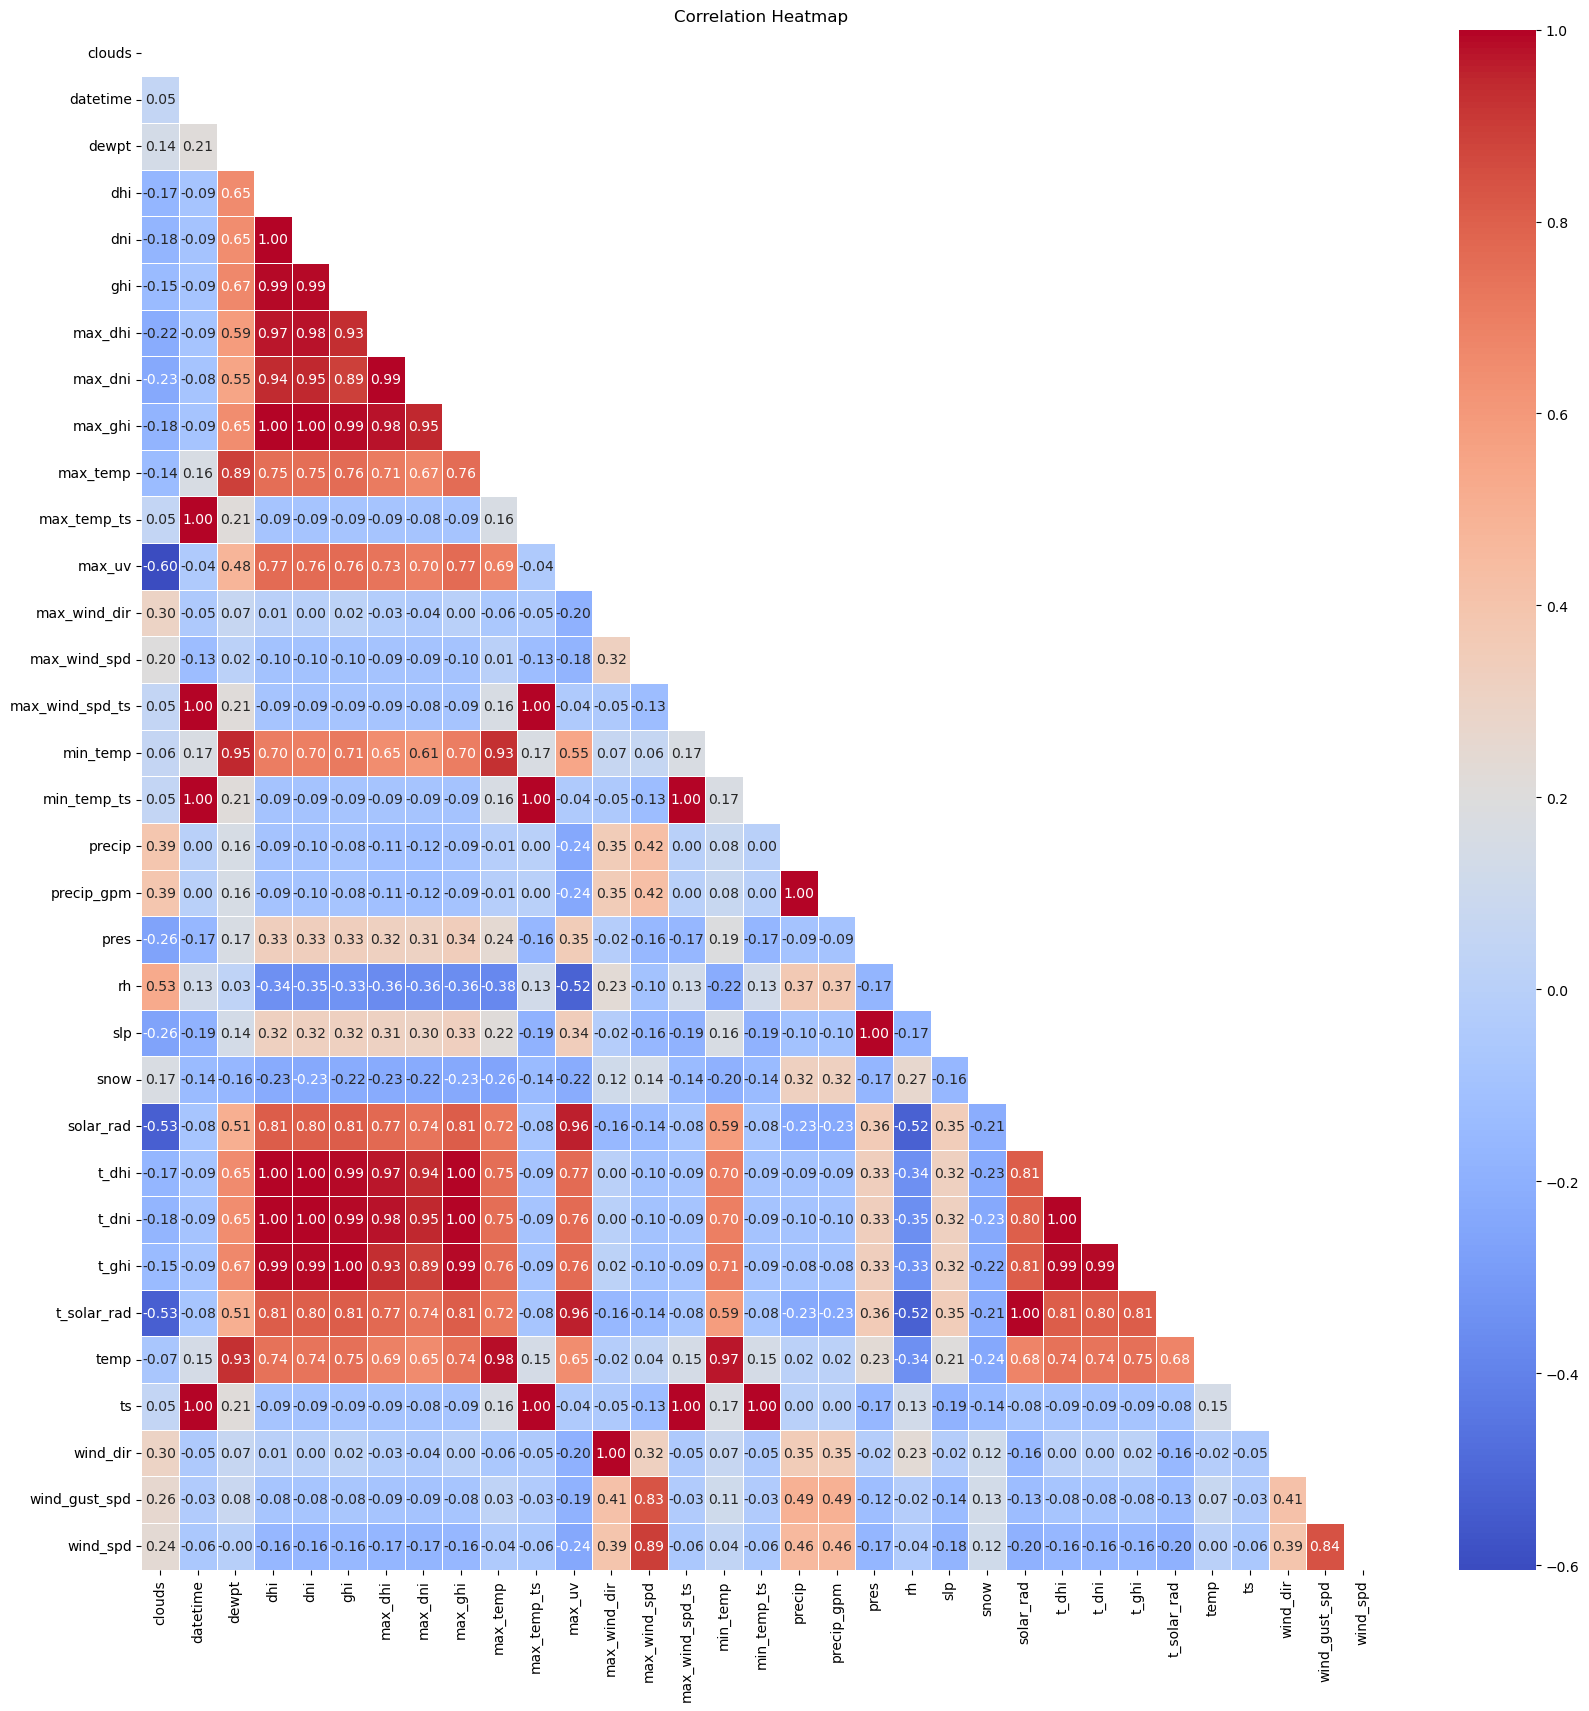

In [21]:
# Correlation heatmap

# Mask for upper-triangular
mask = np.triu(df_7_cleaned.corr())

plt.figure(figsize=(20, 20))

sns.heatmap(df_7_cleaned.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask=mask)

# Show the plot
plt.title("Correlation Heatmap")
plt.show()


***Observation:***
- We can see a lot of highly correlated columns.
- Lets define treshold and have a closer look on them.
- We can drop them as they can influence our results but same time, they can be a valuable.

##### Pros of dropping:
- Reduction in Redundancy: Minimizes redundant information, enhancing dataset efficiency.
- Simplification of Models: Enhances model interpretability and potentially improves performance.
- Computational Efficiency: Reduces computational load with fewer features.
##### Cons of keeping:
- Loss of Information: Removing correlated columns may lead to a loss of valuable insights.
- Overfitting Risk: Correlated features may contribute to predictive power; removal may cause underfitting.
- Context Matters: Decision depends on the analysis context; keeping correlated features can be beneficial in certain cases.

Visual of correlation heatmap with treshold

<Figure size 2000x2000 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap with Threshold')

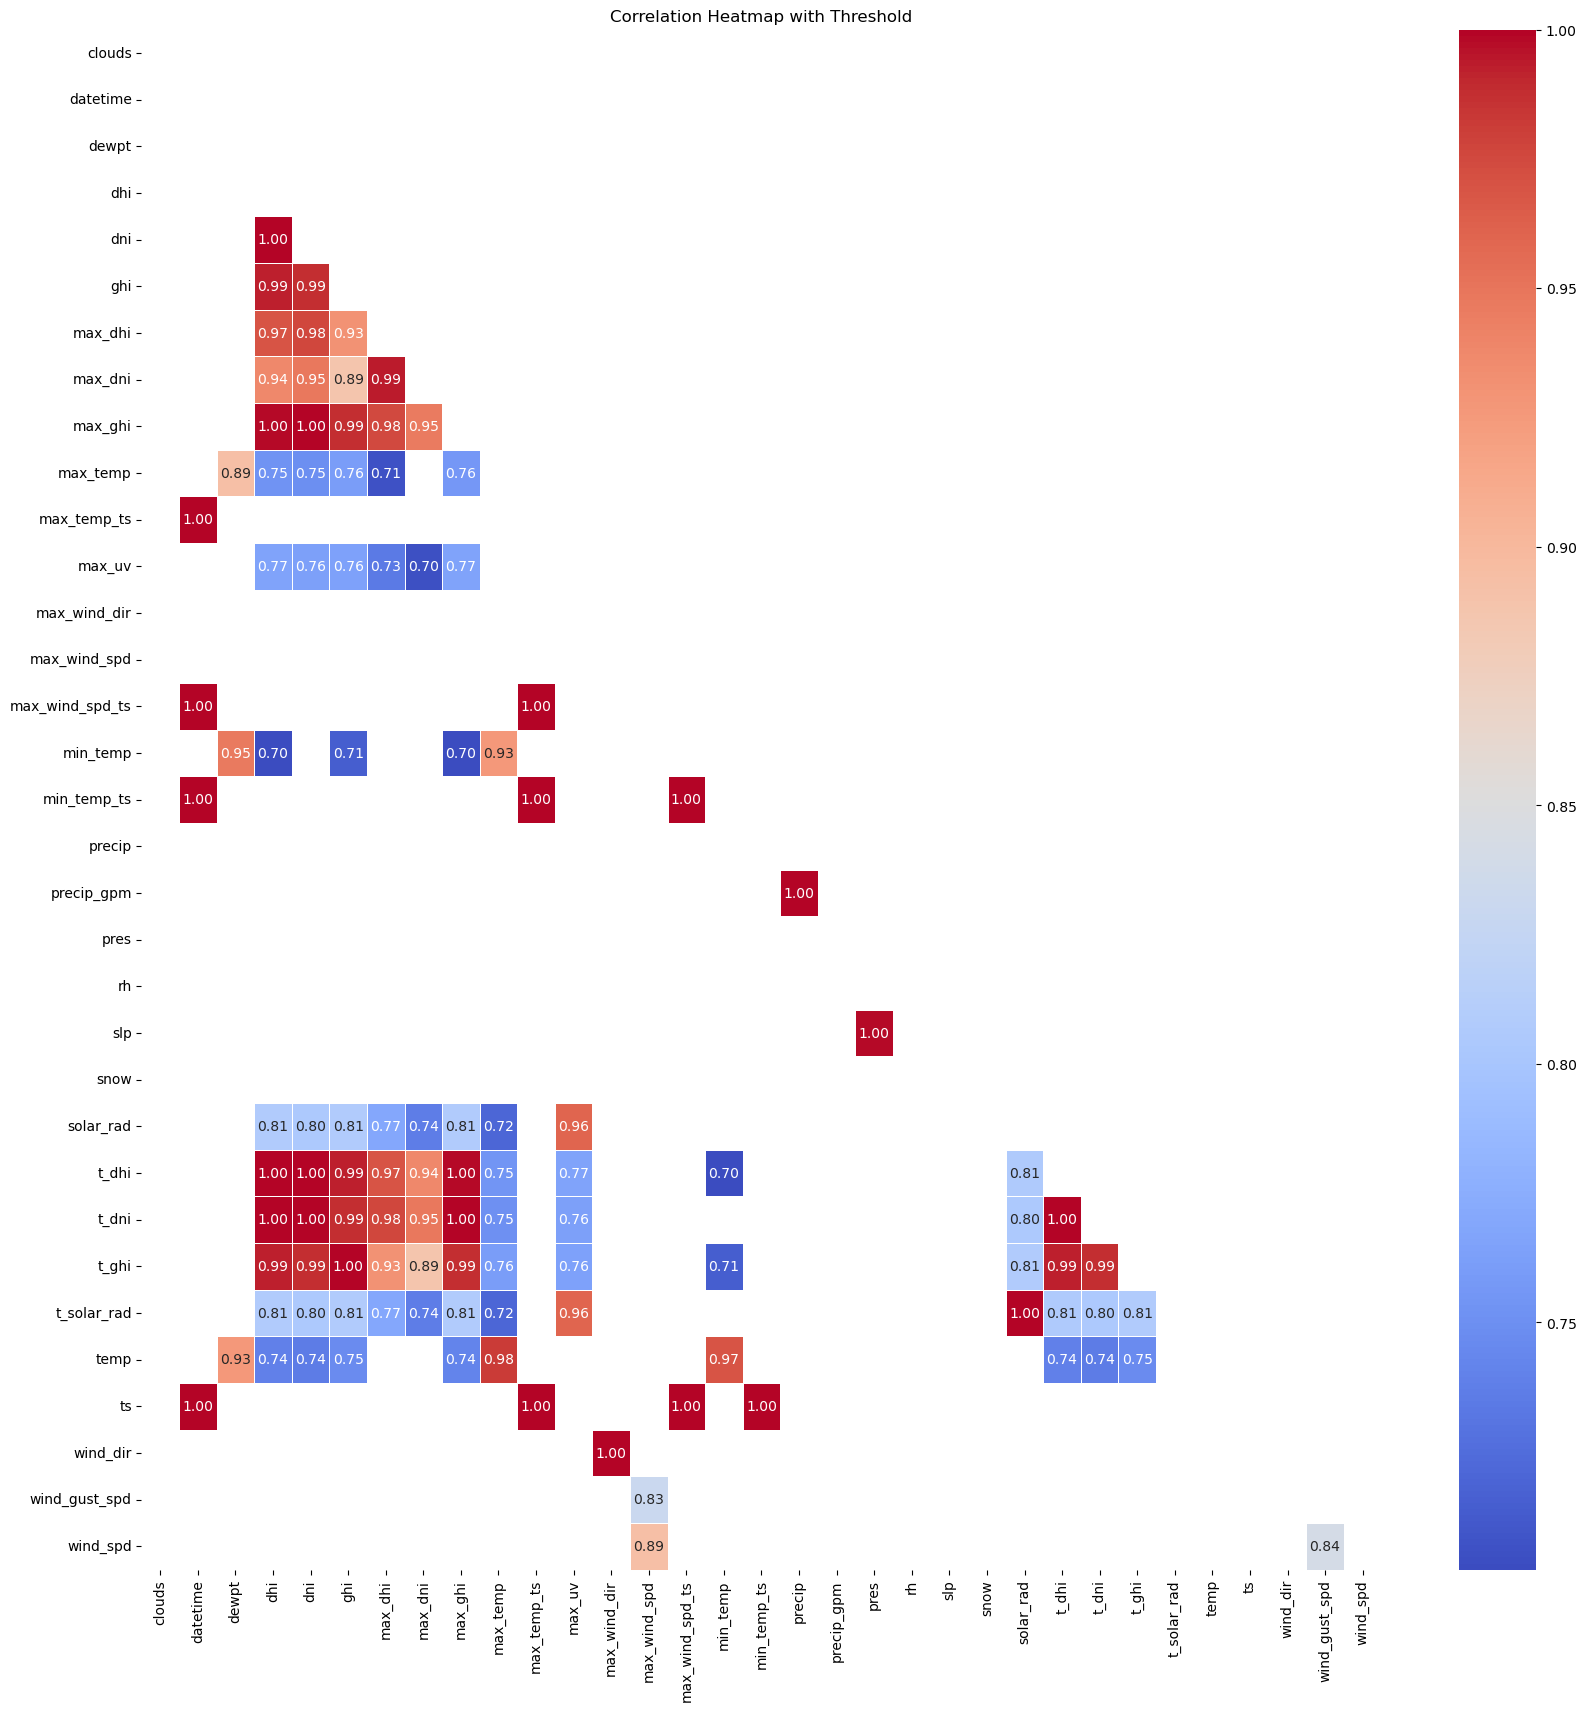

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df_7_cleaned.corr()

# Setting the threshold
threshold = 0.7

# Appling the threshold to the correlation matrix
correlation_matrix_filtered = correlation_matrix[(correlation_matrix > threshold) | (correlation_matrix < -threshold)]

mask = np.triu(correlation_matrix_filtered)
plt.figure(figsize=(20, 20))

sns.heatmap(correlation_matrix_filtered, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, mask = mask)

# Show the plot
plt.title("Correlation Heatmap with Threshold")
plt.show()



We done EDA and Modeling so far, based on them, we will can drop next features.
- `ts, max_wind_spd_ts, wind_spd`
- Also we see that we have regular values `dhi, dni, ghi` columns and their max, min and t versions `max_dhi, min_dni, t_ghi` etc. We can dop them as well, as their highly correlated.

***But we will see if we need to drop them after wi will done merging all the DataFrames and check for feature importans***


In [23]:
'''
# Dropped columns
df_7 = df_7_cleaned.drop(['max_dhi', 'max_dni', 'max_ghi', 'max_temp', 'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',
                 'min_temp', 'min_temp_ts', 't_dhi', 't_dni', 't_ghi', 't_solar_rad'], axis=1)
'''

"\n# Dropped columns\ndf_7 = df_7_cleaned.drop(['max_dhi', 'max_dni', 'max_ghi', 'max_temp', 'max_temp_ts', 'max_uv', 'max_wind_dir', 'max_wind_spd',\n                 'min_temp', 'min_temp_ts', 't_dhi', 't_dni', 't_ghi', 't_solar_rad'], axis=1)\n"

****We done with df_7****

## EDA - df_6

In [24]:
df_6.head()

,Date_from,Date_to,KROPPAN BRU,MOHOLTLIA,SELSBAKK,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen
0,01.12.2018 00:00,01.12.2018 01:00,639,0,0,4,144
1,01.12.2018 01:00,01.12.2018 02:00,487,153,115,21,83
2,01.12.2018 02:00,01.12.2018 03:00,408,85,75,10,69
3,01.12.2018 03:00,01.12.2018 04:00,282,89,56,8,39
4,01.12.2018 04:00,01.12.2018 05:00,165,64,34,3,25


In [25]:
df_6.isna().sum()

Date_from                               0
Date_to                                 0
KROPPAN BRU                             0
MOHOLTLIA                               0
SELSBAKK                                0
MOHOLT RAMPE 2                          0
Jonsvannsveien vest for Steinanvegen    0
dtype: int64

In [26]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Date_from                             10248 non-null  object
 1   Date_to                               10248 non-null  object
 2   KROPPAN BRU                           10248 non-null  object
 3   MOHOLTLIA                             10248 non-null  object
 4   SELSBAKK                              10248 non-null  object
 5   MOHOLT RAMPE 2                        10248 non-null  int64 
 6   Jonsvannsveien vest for Steinanvegen  10248 non-null  int64 
dtypes: int64(2), object(5)
memory usage: 560.6+ KB


Observation:
- `Date_fromand Date_to`-  transformed to datetime format
- `KROPPAN BRU , MOHOLTLIA, SELSBAKK` - transformed to dtype int64

In [27]:
# df_6[['Date_from', 'Date_to']] = df_6[['Date_from', 'Date_to']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M') 
df_6['Date_to'] = df_6['Date_to'].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')


In [28]:
# Sanity check
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date_from                             10248 non-null  object        
 1   Date_to                               10248 non-null  datetime64[ns]
 2   KROPPAN BRU                           10248 non-null  object        
 3   MOHOLTLIA                             10248 non-null  object        
 4   SELSBAKK                              10248 non-null  object        
 5   MOHOLT RAMPE 2                        10248 non-null  int64         
 6   Jonsvannsveien vest for Steinanvegen  10248 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 560.6+ KB


`KROPPAN BRU, MOHOLTLIA, SELSBAKK` - converting to int64

In [29]:
# Checking if it's any values that can't be transformed to numeric.
non_convertible_values_KB = df_6.loc[pd.to_numeric(df_6['KROPPAN BRU'], errors='coerce').isna(), ['KROPPAN BRU']]
print(non_convertible_values_KB)

non_convertible_values_M = df_6.loc[pd.to_numeric(df_6['MOHOLTLIA'], errors='coerce').isna(), ['MOHOLTLIA']]
print(non_convertible_values_M)

non_convertible_values_S = df_6.loc[pd.to_numeric(df_6['SELSBAKK'], errors='coerce').isna(), ['SELSBAKK']]
print(non_convertible_values_S)


     KROPPAN BRU
9228           -
9229           -
     MOHOLTLIA
9301         -
     SELSBAKK
9228        -
9229        -


In [30]:
# Convert string values to int and replace non-numeric values with NaN
df_6['KROPPAN BRU'] = pd.to_numeric(df_6['KROPPAN BRU'], errors='coerce').astype('Int64')
df_6['MOHOLTLIA'] = pd.to_numeric(df_6['MOHOLTLIA'], errors='coerce').astype('Int64')
df_6['SELSBAKK'] = pd.to_numeric(df_6['SELSBAKK'], errors='coerce').astype('Int64')


In [31]:
# Checking if it's any values that can't be transformed to numeric.
non_convertible_values_KB = df_6.loc[pd.to_numeric(df_6['KROPPAN BRU'], errors='coerce').isna(), ['KROPPAN BRU']]
print(non_convertible_values_KB)

non_convertible_values_M = df_6.loc[pd.to_numeric(df_6['MOHOLTLIA'], errors='coerce').isna(), ['MOHOLTLIA']]
print(non_convertible_values_M)

non_convertible_values_S = df_6.loc[pd.to_numeric(df_6['SELSBAKK'], errors='coerce').isna(), ['SELSBAKK']]
print(non_convertible_values_S)


      KROPPAN BRU
9228         <NA>
9229         <NA>
      MOHOLTLIA
9301       <NA>
      SELSBAKK
9228      <NA>
9229      <NA>


In [32]:
df_6[['KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK']].isna().sum()/100

KROPPAN BRU    0.02
MOHOLTLIA      0.01
SELSBAKK       0.02
dtype: float64

As percent of NaN values is to small, deliting them wouldn't affect out dataset

In [33]:
df_6.dropna(subset=['KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK'], inplace=True)

In [34]:
# Sanity check
df_6[['KROPPAN BRU', 'MOHOLTLIA', 'SELSBAKK']].isna().sum()/100

KROPPAN BRU    0.0
MOHOLTLIA      0.0
SELSBAKK       0.0
dtype: float64

In [35]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10245 entries, 0 to 10247
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Date_from                             10245 non-null  object        
 1   Date_to                               10245 non-null  datetime64[ns]
 2   KROPPAN BRU                           10245 non-null  Int64         
 3   MOHOLTLIA                             10245 non-null  Int64         
 4   SELSBAKK                              10245 non-null  Int64         
 5   MOHOLT RAMPE 2                        10245 non-null  int64         
 6   Jonsvannsveien vest for Steinanvegen  10245 non-null  int64         
dtypes: Int64(3), datetime64[ns](1), int64(2), object(1)
memory usage: 670.3+ KB


****We done with df_6****

## EDA - df_5

In [36]:
df_5.head()

,date_from,date_to,month,AMS_kWh,Synthetic_3_6kW,Synthetic_7_2kW,Simultaneous_if_3_6kW
0,02.01.2019 19:00,02.01.2019 20:00,Jan,"0,05","0,06","0,12",1.0
1,02.01.2019 20:00,02.01.2019 21:00,Jan,"6,6","3,6","7,2",1.0
2,02.01.2019 21:00,02.01.2019 22:00,Jan,"6,8","3,6","7,2",1.0
3,02.01.2019 22:00,02.01.2019 23:00,Jan,"1,45","3,6","0,12",1.0
4,02.01.2019 23:00,03.01.2019 00:00,Jan,"0,05","3,6",0,1.0


In [37]:
df_5.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date_from              9466 non-null   object 
 1   date_to                9464 non-null   object 
 2   month                  9466 non-null   object 
 3   AMS_kWh                9458 non-null   object 
 4   Synthetic_3_6kW        8300 non-null   object 
 5   Synthetic_7_2kW        8300 non-null   object 
 6   Simultaneous_if_3_6kW  5188 non-null   float64
dtypes: float64(1), object(6)
memory usage: 517.8+ KB


In [38]:
df_5.isna().sum()

date_from                   0
date_to                     2
month                       0
AMS_kWh                     8
Synthetic_3_6kW          1166
Synthetic_7_2kW          1166
Simultaneous_if_3_6kW    4278
dtype: int64

**Observation:**
- Transformation datetime columns
- Transformation to dtype int64
- We not dropping any missing values here, as we will fill them by merging to other datasets

In [39]:
df_5[['date_from', 'date_to']] = df_5[['date_from', 'date_to']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')


In [40]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_from              9466 non-null   datetime64[ns]
 1   date_to                9464 non-null   datetime64[ns]
 2   month                  9466 non-null   object        
 3   AMS_kWh                9458 non-null   object        
 4   Synthetic_3_6kW        8300 non-null   object        
 5   Synthetic_7_2kW        8300 non-null   object        
 6   Simultaneous_if_3_6kW  5188 non-null   float64       
dtypes: datetime64[ns](2), float64(1), object(4)
memory usage: 517.8+ KB


In [41]:
df_5[['AMS_kWh', 'Synthetic_3_6kW', 'Synthetic_7_2kW']] = df_5[['AMS_kWh', 'Synthetic_3_6kW', 'Synthetic_7_2kW']].replace(',', '.', regex=True).astype(np.float64)


In [42]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_from              9466 non-null   datetime64[ns]
 1   date_to                9464 non-null   datetime64[ns]
 2   month                  9466 non-null   object        
 3   AMS_kWh                9458 non-null   float64       
 4   Synthetic_3_6kW        8300 non-null   float64       
 5   Synthetic_7_2kW        8300 non-null   float64       
 6   Simultaneous_if_3_6kW  5188 non-null   float64       
dtypes: datetime64[ns](2), float64(4), object(1)
memory usage: 517.8+ KB


In [43]:
# Dictionary to map month names to integer values
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Mapping the 'month_plugin' column to integer values
df_5['month'] = df_5['month'].map(month_mapping)


In [44]:
df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9466 entries, 0 to 9465
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_from              9466 non-null   datetime64[ns]
 1   date_to                9464 non-null   datetime64[ns]
 2   month                  9466 non-null   int64         
 3   AMS_kWh                9458 non-null   float64       
 4   Synthetic_3_6kW        8300 non-null   float64       
 5   Synthetic_7_2kW        8300 non-null   float64       
 6   Simultaneous_if_3_6kW  5188 non-null   float64       
dtypes: datetime64[ns](2), float64(4), int64(1)
memory usage: 517.8 KB


****We done with df_5****

## EDA - df_4

In [45]:
df_4.head()

,date_from,daily_hour,weekday,month,Synthetic_3_6kW,Synthetic_7_2kW,Flex_3_6kW,Flex_7_2kW,n_shared
0,10.01.2019 00:00,0,Thursday,Jan,0,0,0,0,1
1,10.01.2019 01:00,1,Thursday,Jan,0,0,0,0,1
2,10.01.2019 02:00,2,Thursday,Jan,0,0,0,0,1
3,10.01.2019 03:00,3,Thursday,Jan,0,0,0,0,1
4,10.01.2019 04:00,4,Thursday,Jan,0,0,0,0,1


In [46]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date_from        9288 non-null   object
 1   daily_hour       9288 non-null   int64 
 2   weekday          9288 non-null   object
 3   month            9288 non-null   object
 4   Synthetic_3_6kW  9288 non-null   object
 5   Synthetic_7_2kW  9288 non-null   object
 6   Flex_3_6kW       9288 non-null   object
 7   Flex_7_2kW       9288 non-null   object
 8   n_shared         9288 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 653.2+ KB


In [47]:
df_4.isna().sum()

date_from          0
daily_hour         0
weekday            0
month              0
Synthetic_3_6kW    0
Synthetic_7_2kW    0
Flex_3_6kW         0
Flex_7_2kW         0
n_shared           0
dtype: int64

**Observation**
- `date_from` - transform to dtype datetime
- `weekday, month` - transform to dtype int64 by using map.
- `Synthetic_3_6kW, Synthetic_7_2kW, Flex_3_6kW, Flex_7_2kW` - transform to dtype int64

In [48]:
df_4['date_from'] = df_4['date_from'].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')


In [49]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_from        9288 non-null   datetime64[ns]
 1   daily_hour       9288 non-null   int64         
 2   weekday          9288 non-null   object        
 3   month            9288 non-null   object        
 4   Synthetic_3_6kW  9288 non-null   object        
 5   Synthetic_7_2kW  9288 non-null   object        
 6   Flex_3_6kW       9288 non-null   object        
 7   Flex_7_2kW       9288 non-null   object        
 8   n_shared         9288 non-null   int64         
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 653.2+ KB


In [50]:
df_4[['Flex_3_6kW', 'Flex_7_2kW', 'Synthetic_3_6kW', 'Synthetic_7_2kW']] = df_4[['Flex_3_6kW', 'Flex_7_2kW', 'Synthetic_3_6kW', 'Synthetic_7_2kW']].replace(',', '.', regex=True).astype(np.float64)


In [51]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_from        9288 non-null   datetime64[ns]
 1   daily_hour       9288 non-null   int64         
 2   weekday          9288 non-null   object        
 3   month            9288 non-null   object        
 4   Synthetic_3_6kW  9288 non-null   float64       
 5   Synthetic_7_2kW  9288 non-null   float64       
 6   Flex_3_6kW       9288 non-null   float64       
 7   Flex_7_2kW       9288 non-null   float64       
 8   n_shared         9288 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 653.2+ KB


In [52]:
# Dictionary to map month names to integer values
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Mapping the 'month_plugin' column to integer values
df_4['month'] = df_4['month'].map(month_mapping)


In [53]:
# Dictionary to map weekdays names to integer values
weekdays_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                    'Friday': 5, 'Saturday': 6,'Sunday': 7}

# Mapping the 'weekdays_plugin' column to integer values
df_4['weekday'] = df_4['weekday'].map(weekdays_mapping)


In [54]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_from        9288 non-null   datetime64[ns]
 1   daily_hour       9288 non-null   int64         
 2   weekday          9288 non-null   int64         
 3   month            9288 non-null   int64         
 4   Synthetic_3_6kW  9288 non-null   float64       
 5   Synthetic_7_2kW  9288 non-null   float64       
 6   Flex_3_6kW       9288 non-null   float64       
 7   Flex_7_2kW       9288 non-null   float64       
 8   n_shared         9288 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 653.2 KB


****We done with df_4****

## EDA - df_3

In [55]:
df_3.head()

,date_from,daily_hour,weekday,month,Synthetic_3_6kW,Synthetic_7_2kW,Flex_3_6kW,Flex_7_2kW,n_private
0,21.12.2018 10:00,10,Friday,Dec,"1,17","1,17",0,"0,174",1
1,21.12.2018 11:00,11,Friday,Dec,"1,62","3,24",0,0,1
2,21.12.2018 12:00,12,Friday,Dec,"3,6","7,2",0,0,1
3,21.12.2018 13:00,13,Friday,Dec,"3,6","7,2",0,0,1
4,21.12.2018 14:00,14,Friday,Dec,"3,6","7,2",0,0,1


In [56]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9757 entries, 0 to 9756
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   date_from        9757 non-null   object
 1   daily_hour       9757 non-null   int64 
 2   weekday          9757 non-null   object
 3   month            9757 non-null   object
 4   Synthetic_3_6kW  9757 non-null   object
 5   Synthetic_7_2kW  9757 non-null   object
 6   Flex_3_6kW       9757 non-null   object
 7   Flex_7_2kW       9757 non-null   object
 8   n_private        9757 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 686.2+ KB


In [57]:
df_3.isna().sum()

date_from          0
daily_hour         0
weekday            0
month              0
Synthetic_3_6kW    0
Synthetic_7_2kW    0
Flex_3_6kW         0
Flex_7_2kW         0
n_private          0
dtype: int64

**Observation**
- `date_from` - transform to dtype datetime
- `weekday, month` - transform to dtype int64 by using map.
- `Synthetic_3_6kW, Synthetic_7_2kW, Flex_3_6kW, Flex_7_2kW` - transform to dtype int64

In [58]:
df_3['date_from'] = df_3['date_from'].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')

In [59]:
# Dictionary to map month names to integer values
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Mapping the 'month_plugin' column to integer values
df_3['month'] = df_3['month'].map(month_mapping)


In [60]:
# Dictionary to map weekdays names to integer values
weekdays_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                    'Friday': 5, 'Saturday': 6,'Sunday': 7}

# Mapping the 'weekdays_plugin' column to integer values
df_3['weekday'] = df_3['weekday'].map(weekdays_mapping)


In [61]:
df_3[['Flex_3_6kW', 'Flex_7_2kW', 'Synthetic_3_6kW', 'Synthetic_7_2kW']] = df_3[['Flex_3_6kW', 'Flex_7_2kW', 'Synthetic_3_6kW', 'Synthetic_7_2kW']].replace(',', '.', regex=True).astype(np.float64)


In [62]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9757 entries, 0 to 9756
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_from        9757 non-null   datetime64[ns]
 1   daily_hour       9757 non-null   int64         
 2   weekday          9757 non-null   int64         
 3   month            9757 non-null   int64         
 4   Synthetic_3_6kW  9757 non-null   float64       
 5   Synthetic_7_2kW  9757 non-null   float64       
 6   Flex_3_6kW       9757 non-null   float64       
 7   Flex_7_2kW       9757 non-null   float64       
 8   n_private        9757 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 686.2 KB


We done with df_3

## EDA - df_2

In [63]:
df_2.head()

,date_from,date_to,User_ID,session_ID,Synthetic_3_6kW,Synthetic_7_2kW,Flex_3_6kW,Flex_7_2kW
0,21.12.2018 10:00,21.12.2018 11:00,AdO3-4,1.0,"0,3","0,3",NaN,"0,06"
1,21.12.2018 10:00,21.12.2018 11:00,AdO3-4,2.0,"0,87","0,87",NaN,"0,114"
2,21.12.2018 11:00,21.12.2018 12:00,AdO3-4,3.0,"1,62","3,24",NaN,NaN
3,21.12.2018 12:00,21.12.2018 13:00,AdO3-4,3.0,"3,6","7,2",NaN,NaN
4,21.12.2018 13:00,21.12.2018 14:00,AdO3-4,3.0,"3,6","7,2",NaN,NaN


In [64]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88156 entries, 0 to 88155
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date_from        88156 non-null  object 
 1   date_to          88156 non-null  object 
 2   User_ID          87766 non-null  object 
 3   session_ID       87766 non-null  float64
 4   Synthetic_3_6kW  31110 non-null  object 
 5   Synthetic_7_2kW  18957 non-null  object 
 6   Flex_3_6kW       62086 non-null  object 
 7   Flex_7_2kW       72624 non-null  object 
dtypes: float64(1), object(7)
memory usage: 5.4+ MB


In [65]:
df_2.isna().sum()

date_from              0
date_to                0
User_ID              390
session_ID           390
Synthetic_3_6kW    57046
Synthetic_7_2kW    69199
Flex_3_6kW         26070
Flex_7_2kW         15532
dtype: int64

**Observation**
- `date_from, date_to` - transform to dtype datetime
- `Synthetic_3_6kW, Synthetic_7_2kW, Flex_3_6kW, Flex_7_2kW` - transform to dtype int64
- `User_ID` - will be transformed by using dummy variables after merging with all datasets.

In [66]:
df_2[['date_from', 'date_to']] = df_2[['date_from', 'date_to']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')


In [67]:
df_2[['Flex_3_6kW', 'Flex_7_2kW', 'Synthetic_3_6kW', 'Synthetic_7_2kW']] = df_2[['Flex_3_6kW', 'Flex_7_2kW', 'Synthetic_3_6kW', 'Synthetic_7_2kW']].replace(',', '.', regex=True).astype(np.float64)


In [68]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88156 entries, 0 to 88155
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date_from        88156 non-null  datetime64[ns]
 1   date_to          88156 non-null  datetime64[ns]
 2   User_ID          87766 non-null  object        
 3   session_ID       87766 non-null  float64       
 4   Synthetic_3_6kW  31110 non-null  float64       
 5   Synthetic_7_2kW  18957 non-null  float64       
 6   Flex_3_6kW       62086 non-null  float64       
 7   Flex_7_2kW       72624 non-null  float64       
dtypes: datetime64[ns](2), float64(5), object(1)
memory usage: 5.4+ MB


We done with df_2

## EDA - df_1

In [69]:
df_1.head()

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,21.12.2018 19:46,19.0,"29,87","8,216388889",Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,23.12.2018 16:40,16.0,"15,56","24,41972222",Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,24.12.2018 23:02,23.0,"3,62","0,970555556",Dec,Monday,late evening (21-midnight),Less than 3 hours


In [70]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   session_ID         6878 non-null   int64  
 1   Garage_ID          6878 non-null   object 
 2   User_ID            6878 non-null   object 
 3   User_type          6878 non-null   object 
 4   Shared_ID          1412 non-null   object 
 5   Start_plugin       6878 non-null   object 
 6   Start_plugin_hour  6878 non-null   int64  
 7   End_plugout        6844 non-null   object 
 8   End_plugout_hour   6844 non-null   float64
 9   El_kWh             6878 non-null   object 
 10  Duration_hours     6844 non-null   object 
 11  month_plugin       6878 non-null   object 
 12  weekdays_plugin    6878 non-null   object 
 13  Plugin_category    6878 non-null   object 
 14  Duration_category  6844 non-null   object 
dtypes: float64(1), int64(2), object(12)
memory usage: 806.1+ KB


In [71]:
df_1.isna().sum()

session_ID              0
Garage_ID               0
User_ID                 0
User_type               0
Shared_ID            5466
Start_plugin            0
Start_plugin_hour       0
End_plugout            34
End_plugout_hour       34
El_kWh                  0
Duration_hours         34
month_plugin            0
weekdays_plugin         0
Plugin_category         0
Duration_category      34
dtype: int64

**Observation**
- `Start_plugin, End_plugout` - transform to dtype datetime
- `Duration_hours, month_plugin, weekdays_plugin, Plugin_category, Duration_category` - transform to dtype int64
- `Garage_ID, User_ID` - will be transformed by using dummy variables after merging with all datasets.
- I would assume that `session_ID` is anytime car was charged and it will be same as our index numbers. We will consider to drop it after checking our baseline model.
- After analyzing data, we can see that  null values in `Shared_ID` column were mirroring Private `User_type` column. And as it was private and was shared with anyone, it was considered as NaN. And we decided to fill the NaN values as a Private values.

In [72]:
df_1['El_kWh'] = df_1['El_kWh'].str.replace(',', '').astype(float)
df_1['Duration_hours'] = df_1['Duration_hours'].str.replace(',', '').astype(float)

In [73]:
# df_1[['Start_plugin', 'End_plugout']] = df_1[['Start_plugin', 'End_plugout']].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')
df_1['End_plugout'] = df_1['End_plugout'].apply(pd.to_datetime, format='%d.%m.%Y %H:%M')


In [74]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   object        
 4   Shared_ID          1412 non-null   object        
 5   Start_plugin       6878 non-null   object        
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  Plugin_category    6878 non-null   object        
 14  Duration

****`Shared_ID`****

In [75]:
# Using filter to look at samples with `Shared_ID` NAN values
df_1[df_1['Shared_ID'].isna()]

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,2018-12-21 10:23:00,10.0,3.0,5.000000e+00,Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,2018-12-21 10:32:00,10.0,87.0,1.366667e+08,Dec,Friday,late morning (9-12),Less than 3 hours
2,3,AdO3,AdO3-4,Private,NaN,21.12.2018 11:33,11,2018-12-21 19:46:00,19.0,2987.0,8.216389e+09,Dec,Friday,late morning (9-12),Between 6 and 9 hours
3,4,AdO3,AdO3-2,Private,NaN,22.12.2018 16:15,16,2018-12-23 16:40:00,16.0,1556.0,2.441972e+09,Dec,Saturday,late afternoon (15-18),More than 18 hours
4,5,AdO3,AdO3-2,Private,NaN,24.12.2018 22:03,22,2018-12-24 23:02:00,23.0,362.0,9.705556e+08,Dec,Monday,late evening (21-midnight),Less than 3 hours
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6872,6873,Bl2,Bl2-1,Private,NaN,31.01.2020 17:42,17,2020-01-31 17:59:00,17.0,101.0,2.877778e+08,Jan,Friday,late afternoon (15-18),Less than 3 hours
6873,6874,UT15,UT15-2,Private,NaN,31.01.2020 17:57,17,2020-01-31 22:29:00,22.0,1343.0,4.530000e+02,Jan,Friday,late afternoon (15-18),Between 3 and 6 hours
6874,6875,AsO10,AsO10-1,Private,NaN,31.01.2020 18:32,18,2020-01-31 21:43:00,21.0,91.0,3.182222e+09,Jan,Friday,early evening (18-21),Between 3 and 6 hours
6875,6876,Bl2,Bl2-1,Private,NaN,31.01.2020 19:25,19,2020-01-31 20:37:00,20.0,428.0,1.203889e+09,Jan,Friday,early evening (18-21),Less than 3 hours


In [76]:
private = (df_1['User_type'] == 'Private') & (df_1['Shared_ID'].isna())
print(private)

0        True
1        True
2        True
3        True
4        True
        ...  
6873     True
6874     True
6875     True
6876     True
6877    False
Length: 6878, dtype: bool


In [77]:
sum(private)

5466

In [78]:
# Replasment with Private
df_1.loc[private, 'Shared_ID'] = 'Private'

In [79]:
# Sanity check
df_1.isna().sum()

session_ID            0
Garage_ID             0
User_ID               0
User_type             0
Shared_ID             0
Start_plugin          0
Start_plugin_hour     0
End_plugout          34
End_plugout_hour     34
El_kWh                0
Duration_hours       34
month_plugin          0
weekdays_plugin       0
Plugin_category       0
Duration_category    34
dtype: int64

In [80]:
# Convert 'User_type' column to binary
df_1['User_type'] = np.where(df_1['User_type'] == 'Private',1,0)
df_1['User_type']

0       1
1       1
2       1
3       1
4       1
       ..
6873    1
6874    1
6875    1
6876    1
6877    0
Name: User_type, Length: 6878, dtype: int64

****`month_plugin`****

In [81]:
# Dictionary to map month names to integer values
month_mapping = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Mapping the 'month_plugin' column to integer values
df_1['month_plugin'] = df_1['month_plugin'].map(month_mapping)


****`weekdays_plugin`****

In [82]:
# Dictionary to map weekdays names to integer values
weekdays_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 
                    'Friday': 5, 'Saturday': 6,'Sunday': 7}

# Mapping the 'weekdays_plugin' column to integer values
df_1['weekdays_plugin'] = df_1['weekdays_plugin'].map(weekdays_mapping)


****`Plugin_category`****

In [83]:
# Dictionary to map Plugin_category names to integer values
Plugin_category_mapping = {'late afternoon (15-18)': 1, 'early evening (18-21)': 2, 'late evening (21-midnight)': 3,
                           'early afternoon (12-15)': 4, 'late morning (9-12)': 5, 'early morning (6-9)': 6,
                           'early night (midnight-3)': 7, 'late night (3-6)': 8}

# Mapping the 'Plugin_category' column to integer values
df_1['Plugin_category'] = df_1['Plugin_category'].map(Plugin_category_mapping)


****`Duration_category`****

In [84]:
# Dictionary to map Duration_category names to integer values
Duration_category_mapping = {'Less than 3 hours': 1, 'More than 18 hours': 2, 'Between 9 and 12 hours': 3, 
                             'Between 12 and 15 hours': 4, 'Between 3 and 6 hours': 5, 
                             'Between 15 and 18 hours': 6,'Between 6 and 9  hours': 7}

# Mapping the 'Plugin_category' column to integer values
df_1['Duration_category'] = df_1['Duration_category'].map(Duration_category_mapping)


****`Shared_ID`****

Mapping by using value_counts

In [85]:
df_1['Shared_ID'].value_counts()

Shared_ID
Private      5466
Shared-12     345
Shared-5      313
Shared-6      273
Shared-7      153
Shared-4      138
Shared-11      76
Shared-3       33
Shared-8       32
Shared-2       16
Shared-1       16
Shared-10      15
Shared-9        2
Name: count, dtype: int64

In [86]:
# Dictionary to map 'Shared_ID' values to integer values
shared_id_mapping = {'Private': 5418, 'Shared-12': 343, 'Shared-5': 313, 'Shared-6': 273, 'Shared-7': 152, 
                     'Shared-4': 138, 'Shared-11': 75, 'Shared-3': 33, 'Shared-8': 32, 'Shared-2': 16,
                     'Shared-1': 16, 'Shared-10': 8, 'Shared-9': 2
}

# Mapping the 'Shared_ID' column to integer values
df_1['Shared_ID'] = df_1['Shared_ID'].map(shared_id_mapping)

In [87]:
# Sanity check
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   int64         
 4   Shared_ID          6878 non-null   int64         
 5   Start_plugin       6878 non-null   object        
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   int64         
 12  weekdays_plugin    6878 non-null   int64         
 13  Plugin_category    6878 non-null   int64         
 14  Duration

### Merge Process
- First, we will merge df_1 with df_6 and then merge it with df_7
- Second, we will merge df_2 with df_3 and with df_4 and df_5
- Third, we will merhe first and second step together

#### Observation
- I have 7 DataFrames, and some of them have missing values. However, in the common columns, there are instances where one dataset has missing values, and another dataset has complete values. My goal is to fill in the missing values in one DataFrame using the values from another DataFrame. 
- I will use outer join, left or right join because I want to retain all rows from both datasets, merging them based on the common columns, and filling missing values where possible.
This approach is sensible, especially if we want to maximize the utilization of available data and avoid losing rows with missing values. 

***merge df_1 with df_6***

In [88]:
df_1.info()
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_ID         6878 non-null   int64         
 1   Garage_ID          6878 non-null   object        
 2   User_ID            6878 non-null   object        
 3   User_type          6878 non-null   int64         
 4   Shared_ID          6878 non-null   int64         
 5   Start_plugin       6878 non-null   object        
 6   Start_plugin_hour  6878 non-null   int64         
 7   End_plugout        6844 non-null   datetime64[ns]
 8   End_plugout_hour   6844 non-null   float64       
 9   El_kWh             6878 non-null   float64       
 10  Duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   int64         
 12  weekdays_plugin    6878 non-null   int64         
 13  Plugin_category    6878 non-null   int64         
 14  Duration

In [89]:
df_1.shape
df_6.shape

(6878, 15)

(10245, 7)

In [90]:
df_1['Start_plugin'] = pd.to_datetime(df_1['Start_plugin'], format='%d.%m.%Y %H:%M')

df_1['Start_plugin'] = df_1['Start_plugin'].dt.strftime('%d.%m.%Y %H:00')

In [91]:
df_1['Start_plugin'].head()
df_6['Date_from'].head()

0    21.12.2018 10:00
1    21.12.2018 10:00
2    21.12.2018 11:00
3    22.12.2018 16:00
4    24.12.2018 22:00
Name: Start_plugin, dtype: object

0    01.12.2018 00:00
1    01.12.2018 01:00
2    01.12.2018 02:00
3    01.12.2018 03:00
4    01.12.2018 04:00
Name: Date_from, dtype: object

In [92]:
# Merge the data based on the hour values
merged_data = df_1.merge(df_6, left_on='Start_plugin', right_on='Date_from', )

# Drop unnecessary date and hour columns
merged_data.drop([], axis=1, inplace=True)

In [93]:
merged_data.shape

(6866, 22)

In [94]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6866 entries, 0 to 6865
Data columns (total 22 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   session_ID                            6866 non-null   int64         
 1   Garage_ID                             6866 non-null   object        
 2   User_ID                               6866 non-null   object        
 3   User_type                             6866 non-null   int64         
 4   Shared_ID                             6866 non-null   int64         
 5   Start_plugin                          6866 non-null   object        
 6   Start_plugin_hour                     6866 non-null   int64         
 7   End_plugout                           6833 non-null   datetime64[ns]
 8   End_plugout_hour                      6833 non-null   float64       
 9   El_kWh                                6866 non-null   float64       
 10  

In [95]:
merged_data.isna().sum()

session_ID                               0
Garage_ID                                0
User_ID                                  0
User_type                                0
Shared_ID                                0
Start_plugin                             0
Start_plugin_hour                        0
End_plugout                             33
End_plugout_hour                        33
El_kWh                                   0
Duration_hours                          33
month_plugin                             0
weekdays_plugin                          0
Plugin_category                          0
Duration_category                       33
Date_from                                0
Date_to                                  0
KROPPAN BRU                              0
MOHOLTLIA                                0
SELSBAKK                                 0
MOHOLT RAMPE 2                           0
Jonsvannsveien vest for Steinanvegen     0
dtype: int64

***merge with df_7***

In [96]:
merged_data['Start_plugin'] = pd.to_datetime(merged_data['Start_plugin'], format='%d.%m.%Y %H:%M')

merged_data['Start_plugin_date'] = merged_data['Start_plugin'].dt.date

In [97]:
merged_data['Start_plugin_date'] = pd.to_datetime(merged_data['Start_plugin_date'])

In [98]:
# Merge the data based on the hour values
merged_data = merged_data.merge(df_7_cleaned, left_on='Start_plugin_date', right_on='datetime')

# Drop unnecessary date and hour columns
merged_data.drop(['Date_from', 'Date_to', 'datetime'], axis=1, inplace=True)

In [99]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6866 entries, 0 to 6865
Data columns (total 53 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   session_ID                            6866 non-null   int64         
 1   Garage_ID                             6866 non-null   object        
 2   User_ID                               6866 non-null   object        
 3   User_type                             6866 non-null   int64         
 4   Shared_ID                             6866 non-null   int64         
 5   Start_plugin                          6866 non-null   datetime64[ns]
 6   Start_plugin_hour                     6866 non-null   int64         
 7   End_plugout                           6833 non-null   datetime64[ns]
 8   End_plugout_hour                      6833 non-null   float64       
 9   El_kWh                                6866 non-null   float64       
 10  

In [100]:
merged_data.shape

(6866, 53)

***merge with df_5***

In [101]:
# Merge df_2, df_3, and df_4 based on the date_from column
merged_data2 = df_2.merge(df_3, on='date_from', how='inner', suffixes=('_x', '_y'))
merged_data3 = merged_data2.merge(df_4, on='date_from', how='inner', suffixes=('_x', '_y'))
merged_data4 = merged_data3.merge(df_5, on='date_from', how='inner', suffixes=('_df4', '_df5'))

# Identify duplicated columns
duplicates = [col[:-2] for col in merged_data4.columns if col.endswith(('_x', '_y'))]

# Fill missing values using duplicated columns
for col in duplicates:
    merged_data4[col] = merged_data4[col + '_x'].combine_first(merged_data4[col + '_y'])

# Drop duplicated columns
merged_data4.drop(columns=[col + '_x' for col in duplicates] + [col + '_y' for col in duplicates], inplace=True)


In [102]:
merged_data4.head()

,date_from,date_to_df4,User_ID,session_ID,n_private,Synthetic_3_6kW_df4,Synthetic_7_2kW_df4,Flex_3_6kW,Flex_7_2kW,n_shared,date_to_df5,month,AMS_kWh,Synthetic_3_6kW_df5,Synthetic_7_2kW_df5,Simultaneous_if_3_6kW,Synthetic_3_6kW,Synthetic_7_2kW,daily_hour,weekday
0,2019-01-10 00:00:00,2019-01-10 01:00:00,AdO1-2,25.0,5,0.0,0.0,3.6,7.2,1,2019-01-10 01:00:00,1,0.00,0.0,0.0,NaN,0.0,0.0,0,4
1,2019-01-10 00:00:00,2019-01-10 01:00:00,Bl2-4,24.0,5,0.0,0.0,3.6,7.2,1,2019-01-10 01:00:00,1,0.00,0.0,0.0,NaN,0.0,0.0,0,4
2,2019-01-10 01:00:00,2019-01-10 02:00:00,Bl2-4,24.0,5,0.0,0.0,3.6,7.2,1,2019-01-10 02:00:00,1,0.05,0.0,0.0,NaN,0.0,0.0,1,4
3,2019-01-10 01:00:00,2019-01-10 02:00:00,AdO1-2,25.0,5,0.0,0.0,3.6,7.2,1,2019-01-10 02:00:00,1,0.05,0.0,0.0,NaN,0.0,0.0,1,4
4,2019-01-10 02:00:00,2019-01-10 03:00:00,AdO1-2,25.0,5,0.0,0.0,3.6,7.2,1,2019-01-10 03:00:00,1,0.05,0.0,0.0,NaN,0.0,0.0,2,4


In [103]:
merged_data4.shape

(87737, 20)

In [104]:
merged_data4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87737 entries, 0 to 87736
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date_from              87737 non-null  datetime64[ns]
 1   date_to_df4            87737 non-null  datetime64[ns]
 2   User_ID                87575 non-null  object        
 3   session_ID             87575 non-null  float64       
 4   n_private              87737 non-null  int64         
 5   Synthetic_3_6kW_df4    87737 non-null  float64       
 6   Synthetic_7_2kW_df4    87737 non-null  float64       
 7   Flex_3_6kW             87737 non-null  float64       
 8   Flex_7_2kW             87737 non-null  float64       
 9   n_shared               87737 non-null  int64         
 10  date_to_df5            87735 non-null  datetime64[ns]
 11  month                  87737 non-null  int64         
 12  AMS_kWh                87707 non-null  float64       
 13  S

In [105]:
merged_data4.isna().sum()

date_from                    0
date_to_df4                  0
User_ID                    162
session_ID                 162
n_private                    0
Synthetic_3_6kW_df4          0
Synthetic_7_2kW_df4          0
Flex_3_6kW                   0
Flex_7_2kW                   0
n_shared                     0
date_to_df5                  2
month                        0
AMS_kWh                     30
Synthetic_3_6kW_df5       2320
Synthetic_7_2kW_df5       2320
Simultaneous_if_3_6kW    26279
Synthetic_3_6kW              0
Synthetic_7_2kW              0
daily_hour                   0
weekday                      0
dtype: int64

***Final merge***

In [106]:
final = merged_data.merge(merged_data4, on=['session_ID', 'User_ID'], how='left', suffixes=('_merged_data', '_merged_data4'))
final = final[~final.duplicated(['session_ID', 'User_ID'], keep='first')]


In [107]:
final.shape

(6866, 71)

In [108]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   session_ID                            6866 non-null   int64         
 1   Garage_ID                             6866 non-null   object        
 2   User_ID                               6866 non-null   object        
 3   User_type                             6866 non-null   int64         
 4   Shared_ID                             6866 non-null   int64         
 5   Start_plugin                          6866 non-null   datetime64[ns]
 6   Start_plugin_hour                     6866 non-null   int64         
 7   End_plugout                           6833 non-null   datetime64[ns]
 8   End_plugout_hour                      6833 non-null   float64       
 9   El_kWh                                6866 non-null   float64       
 10  Dura

We can see dublicated columns `'Synthetic_3_6kW_df4', 'Synthetic_7_2kW_df4', 'Synthetic_3_6kW_df5', 'Synthetic_7_2kW_df5', 'date_to_df5', 'date_to_df5', 'date_from', 'date_to_df4', 'month', 'daily_hour', 'weekday'`, that we got after merging. 

We will drop them

In [109]:
final = final.drop(['Synthetic_3_6kW_df4', 'Synthetic_7_2kW_df4', 'Synthetic_3_6kW_df5', 
                    'Synthetic_7_2kW_df5', 'date_to_df5', 'date_to_df5', 'date_from', 'date_to_df4',
                   'month', 'daily_hour', 'weekday'], axis=1)

In [110]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   session_ID                            6866 non-null   int64         
 1   Garage_ID                             6866 non-null   object        
 2   User_ID                               6866 non-null   object        
 3   User_type                             6866 non-null   int64         
 4   Shared_ID                             6866 non-null   int64         
 5   Start_plugin                          6866 non-null   datetime64[ns]
 6   Start_plugin_hour                     6866 non-null   int64         
 7   End_plugout                           6833 non-null   datetime64[ns]
 8   End_plugout_hour                      6833 non-null   float64       
 9   El_kWh                                6866 non-null   float64       
 10  Dura

In [111]:
for column in final.columns:
    nan_count = final[column].isna().sum()
    if nan_count > 0:
        print(f"Column '{column}' has {nan_count} NaN values.")


Column 'End_plugout' has 33 NaN values.
Column 'End_plugout_hour' has 33 NaN values.
Column 'Duration_hours' has 33 NaN values.
Column 'Duration_category' has 33 NaN values.
Column 'n_private' has 25 NaN values.
Column 'Flex_3_6kW' has 25 NaN values.
Column 'Flex_7_2kW' has 25 NaN values.
Column 'n_shared' has 25 NaN values.
Column 'AMS_kWh' has 25 NaN values.
Column 'Simultaneous_if_3_6kW' has 831 NaN values.
Column 'Synthetic_3_6kW' has 25 NaN values.
Column 'Synthetic_7_2kW' has 25 NaN values.


In [113]:
# Identify numeric columns
numeric_columns = final.select_dtypes(include=['number']).columns

# Fill NaN values with the median for numeric columns
final[numeric_columns] = final[numeric_columns].fillna(final[numeric_columns].median())


In [114]:
# Saving our DataFrame
final.to_csv('/Users/zhassulan/Desktop/Capstone Project/energy_consumption_no_dummy.csv', index=False)

## Feature engineering

Transforming features

In [115]:
# Let's have a look on our categorical features
final.select_dtypes(include=['object']).head()


,Garage_ID,User_ID
0,AdO3,AdO3-4
1,AdO3,AdO3-4
2,AdO3,AdO3-4
3,AdO3,AdO3-2
4,AdO3,AdO3-2


In [116]:
# Transforming by using one-hot encoding
final = pd.get_dummies(final, columns=['Garage_ID'], prefix='Garage_ID', dtype=int, drop_first=True)
final = pd.get_dummies(final, columns=['User_ID'], prefix='User_ID', dtype=int, drop_first=True)

WE are fropping first column to avoid multicoliniarity.

Extract features from datetime columns.

In [117]:
final[['Start_plugin','month_plugin', 'weekdays_plugin', 'Start_plugin_date', 'Start_plugin_hour', 'End_plugout','End_plugout_hour', 'Duration_hours', 'Plugin_category', 'Duration_category']].head()


,Start_plugin,month_plugin,weekdays_plugin,Start_plugin_date,Start_plugin_hour,End_plugout,End_plugout_hour,Duration_hours,Plugin_category,Duration_category
0,2018-12-21 10:00:00,12,5,2018-12-21,10,2018-12-21 10:23:00,10.0,5.000000e+00,5,1.0
1,2018-12-21 10:00:00,12,5,2018-12-21,10,2018-12-21 10:32:00,10.0,1.366667e+08,5,1.0
2,2018-12-21 11:00:00,12,5,2018-12-21,11,2018-12-21 19:46:00,19.0,8.216389e+09,5,7.0
3,2018-12-22 16:00:00,12,6,2018-12-22,16,2018-12-23 16:40:00,16.0,2.441972e+09,1,2.0
4,2018-12-24 22:00:00,12,1,2018-12-24,22,2018-12-24 23:02:00,23.0,9.705556e+08,3,1.0


In [118]:
# Sanity check
final[['Start_plugin','month_plugin', 'weekdays_plugin', 'Start_plugin_date', 'Start_plugin_hour', 'End_plugout','End_plugout_hour', 'Duration_hours', 'Plugin_category', 'Duration_category']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Start_plugin       6866 non-null   datetime64[ns]
 1   month_plugin       6866 non-null   int64         
 2   weekdays_plugin    6866 non-null   int64         
 3   Start_plugin_date  6866 non-null   datetime64[ns]
 4   Start_plugin_hour  6866 non-null   int64         
 5   End_plugout        6833 non-null   datetime64[ns]
 6   End_plugout_hour   6866 non-null   float64       
 7   Duration_hours     6866 non-null   float64       
 8   Plugin_category    6866 non-null   int64         
 9   Duration_category  6866 non-null   float64       
dtypes: datetime64[ns](3), float64(3), int64(4)
memory usage: 590.0 KB


***Observation***
- The year, month, and weekdays for "Start_plugin" could be the same as those for "End_plugout".

Let's check it

In [119]:
# Creating a new boolean columns, where each entry is True if the year, 
# month, week are the same and False otherwise.
final['same_year'] = final['Start_plugin_date'].dt.year == final['End_plugout'].dt.year
final['same_month'] = final['Start_plugin_date'].dt.month == final['End_plugout'].dt.month
final['same_weekday'] = final['Start_plugin_date'].dt.weekday == final['End_plugout'].dt.weekday

print(final[['same_year', 'same_month', 'same_weekday']])


       same_year  same_month  same_weekday
0           True        True          True
1           True        True          True
2           True        True          True
3           True        True         False
4           True        True          True
...          ...         ...           ...
87513       True        True          True
87519       True        True          True
87523       True        True          True
87525       True        True          True
87527       True        True          True

[6866 rows x 3 columns]


In [120]:
# Count values of True and False
false_counts_same_month = filtered_rows['same_month'].value_counts()
false_counts_same_weekday = filtered_rows['same_weekday'].value_counts()
false_counts_same_year = filtered_rows['same_year'].value_counts()

print("Value counts for 'same_month' column:")
print(false_counts_same_month)

print("\nValue counts for 'same_weekday' column:")
print(false_counts_same_weekday)

print("\nValue counts for 'same_year' column:")
print(false_counts_same_year)


NameError: name 'filtered_rows' is not defined

In [121]:
# Drop the created boolean columns
final.drop(['same_year', 'same_month', 'same_weekday'], axis=1, inplace=True)

****Conclusion:****
- We will extract `year`, `month`, `week`, `day`, `hour`, `minutes` from our daytime format features for both `Start_plugin` and `End_plugout`
- We will drop datetime format columns, as we extracted meaningul features as numerical values.

In [123]:
# Extracting values and filling missing values
final['End_plugout_year'] = final['End_plugout'].dt.year.fillna(0).astype('int64')
final['End_plugout_month'] = final['End_plugout'].dt.month.fillna(0).astype('int64')
final['End_plugout_week'] = final['End_plugout'].dt.dayofweek.fillna(0).astype('int64')
final['End_plugout_day'] = final['End_plugout'].dt.day.fillna(0).astype('int64')
final['End_plugout_minute'] = final['End_plugout'].dt.minute.fillna(0).astype('int64')

final['Start_plugin_year'] = final['Start_plugin'].dt.year.fillna(0).astype('int64')
final['Start_plugin_day'] = final['Start_plugin'].dt.day.fillna(0).astype('int64')
final['Start_plugin_minute'] = final['Start_plugin'].dt.minute.fillna(0).astype('int64')


In [124]:
# Drop the created Datetime features
final.drop(['Start_plugin', 'End_plugout', 'Start_plugin_date'], axis=1, inplace=True)

In [125]:
final.shape

(6866, 183)

In [126]:
# Let's have a look on the features that represent time
final[['Start_plugin_year', 'month_plugin', 'weekdays_plugin', 'Start_plugin_day', 'Start_plugin_hour', 
       'Start_plugin_minute', 'End_plugout_year', 'End_plugout_month', 'End_plugout_week',  
       'End_plugout_day', 'End_plugout_hour',  'End_plugout_minute', 'Duration_hours', 'Plugin_category', 
       'Duration_category']].head()



,Start_plugin_year,month_plugin,weekdays_plugin,Start_plugin_day,Start_plugin_hour,Start_plugin_minute,End_plugout_year,End_plugout_month,End_plugout_week,End_plugout_day,End_plugout_hour,End_plugout_minute,Duration_hours,Plugin_category,Duration_category
0,2018,12,5,21,10,0,2018,12,4,21,10.0,23,5.000000e+00,5,1.0
1,2018,12,5,21,10,0,2018,12,4,21,10.0,32,1.366667e+08,5,1.0
2,2018,12,5,21,11,0,2018,12,4,21,19.0,46,8.216389e+09,5,7.0
3,2018,12,6,22,16,0,2018,12,6,23,16.0,40,2.441972e+09,1,2.0
4,2018,12,1,24,22,0,2018,12,0,24,23.0,2,9.705556e+08,3,1.0


In [127]:
# dtype check
final[['month_plugin', 'weekdays_plugin', 'Start_plugin_hour','End_plugout_hour', 'Duration_hours', 
       'Plugin_category', 'Duration_category','End_plugout_year', 'End_plugout_month', 
       'End_plugout_week', 'End_plugout_day', 'End_plugout_minute','Start_plugin_year', 
       'Start_plugin_day', 'Start_plugin_minute']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   month_plugin         6866 non-null   int64  
 1   weekdays_plugin      6866 non-null   int64  
 2   Start_plugin_hour    6866 non-null   int64  
 3   End_plugout_hour     6866 non-null   float64
 4   Duration_hours       6866 non-null   float64
 5   Plugin_category      6866 non-null   int64  
 6   Duration_category    6866 non-null   float64
 7   End_plugout_year     6866 non-null   int64  
 8   End_plugout_month    6866 non-null   int64  
 9   End_plugout_week     6866 non-null   int64  
 10  End_plugout_day      6866 non-null   int64  
 11  End_plugout_minute   6866 non-null   int64  
 12  Start_plugin_year    6866 non-null   int64  
 13  Start_plugin_day     6866 non-null   int64  
 14  Start_plugin_minute  6866 non-null   int64  
dtypes: float64(3), int64(12)
memory usage: 858

In [128]:
# Cheking if we have ony categorical values
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Columns: 183 entries, session_ID to Start_plugin_minute
dtypes: Int64(3), float64(24), int64(156)
memory usage: 9.7 MB


In [129]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Display information for the first 100 columns
print("Information for the first 100 columns:")
print(final.iloc[:, :100].info())


Information for the first 100 columns:
<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Data columns (total 100 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   session_ID                            6866 non-null   int64  
 1   User_type                             6866 non-null   int64  
 2   Shared_ID                             6866 non-null   int64  
 3   Start_plugin_hour                     6866 non-null   int64  
 4   End_plugout_hour                      6866 non-null   float64
 5   El_kWh                                6866 non-null   float64
 6   Duration_hours                        6866 non-null   float64
 7   month_plugin                          6866 non-null   int64  
 8   weekdays_plugin                       6866 non-null   int64  
 9   Plugin_category                       6866 non-null   int64  
 10  Duration_category                     6866 non-n

In [130]:
# Display information for the last 100 columns
print("\n" + "=" * 50 + "\n") 
print("Information for the last 100 columns:")
print(final.iloc[:, -100:].info())



Information for the last 100 columns:
<class 'pandas.core.frame.DataFrame'>
Index: 6866 entries, 0 to 87527
Data columns (total 100 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   User_ID_AdO1-4       6866 non-null   int64
 1   User_ID_AdO3-1       6866 non-null   int64
 2   User_ID_AdO3-2       6866 non-null   int64
 3   User_ID_AdO3-3       6866 non-null   int64
 4   User_ID_AdO3-4       6866 non-null   int64
 5   User_ID_AsO10-1      6866 non-null   int64
 6   User_ID_AsO10-2      6866 non-null   int64
 7   User_ID_AsO10-3      6866 non-null   int64
 8   User_ID_AsO10-4      6866 non-null   int64
 9   User_ID_AsO10-5      6866 non-null   int64
 10  User_ID_AsO2-1       6866 non-null   int64
 11  User_ID_AsO4-1       6866 non-null   int64
 12  User_ID_AsO4-2       6866 non-null   int64
 13  User_ID_AsO4-3       6866 non-null   int64
 14  User_ID_AsO6-1       6866 non-null   int64
 15  User_ID_AsO8-1       6866 non-null 

In [131]:
# to display every feature in our DataFrame
from IPython.display import display

# Display the DataFrame
display(final)


,session_ID,User_type,Shared_ID,Start_plugin_hour,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category,KROPPAN BRU,MOHOLTLIA,SELSBAKK,MOHOLT RAMPE 2,Jonsvannsveien vest for Steinanvegen,clouds,dewpt,dhi,dni,ghi,max_dhi,max_dni,max_ghi,max_temp,max_temp_ts,max_uv,max_wind_dir,max_wind_spd,max_wind_spd_ts,min_temp,min_temp_ts,precip,precip_gpm,pres,rh,slp,snow,solar_rad,t_dhi,t_dni,t_ghi,t_solar_rad,temp,ts,wind_dir,wind_gust_spd,wind_spd,n_private,Flex_3_6kW,Flex_7_2kW,n_shared,AMS_kWh,Simultaneous_if_3_6kW,Synthetic_3_6kW,Synthetic_7_2kW,Garage_ID_AdA6,Garage_ID_AdO1,Garage_ID_AdO3,Garage_ID_AsO10,Garage_ID_AsO2,Garage_ID_AsO4,Garage_ID_AsO6,Garage_ID_AsO8,Garage_ID_Bl2,Garage_ID_Bl7,Garage_ID_MS1,Garage_ID_MS11,Garage_ID_MS22,Garage_ID_NR1,Garage_ID_Ris,Garage_ID_SR14,Garage_ID_SR2,Garage_ID_SR4,Garage_ID_UT1,Garage_ID_UT15,Garage_ID_UT2,Garage_ID_UT7,Garage_ID_UT9,User_ID_AdA6-1,User_ID_AdO1-1,User_ID_AdO1-2,User_ID_AdO1-3,User_ID_AdO1-4,User_ID_AdO3-1,User_ID_AdO3-2,User_ID_AdO3-3,User_ID_AdO3-4,User_ID_AsO10-1,User_ID_AsO10-2,User_ID_AsO10-3,User_ID_AsO10-4,User_ID_AsO10-5,User_ID_AsO2-1,User_ID_AsO4-1,User_ID_AsO4-2,User_ID_AsO4-3,User_ID_AsO6-1,User_ID_AsO8-1,User_ID_AsO8-2,User_ID_AsO8-3,User_ID_AsO8-4,User_ID_Bl2-1,User_ID_Bl2-2,User_ID_Bl2-3,User_ID_Bl2-4,User_ID_Bl2-5,User_ID_Bl2-6,User_ID_Bl2-7,User_ID_Bl2-8,User_ID_Bl7-1,User_ID_MS1-1,User_ID_MS1-2,User_ID_MS11-1,User_ID_MS22-1,User_ID_NR1-1,User_ID_NR1-2,User_ID_NR1-3,User_ID_Ris-1,User_ID_Ris-2,User_ID_Ris-3,User_ID_SR14-1,User_ID_SR14-2,User_ID_SR2-1,User_ID_SR2-2,User_ID_SR2-3,User_ID_SR4-1,User_ID_Share-1,User_ID_Share-10,User_ID_Share-11,User_ID_Share-12,User_ID_Share-13,User_ID_Share-14,User_ID_Share-15,User_ID_Share-16,User_ID_Share-17,User_ID_Share-18,User_ID_Share-19,User_ID_Share-2,User_ID_Share-20,User_ID_Share-21,User_ID_Share-22,User_ID_Share-23,User_ID_Share-24,User_ID_Share-25,User_ID_Share-26,User_ID_Share-27,User_ID_Share-28,User_ID_Share-29,User_ID_Share-3,User_ID_Share-30,User_ID_Share-31,User_ID_Share-32,User_ID_Share-33,User_ID_Share-34,User_ID_Share-35,User_ID_Share-36,User_ID_Share-37,User_ID_Share-38,User_ID_Share-39,User_ID_Share-4,User_ID_Share-5,User_ID_Share-6,User_ID_Share-7,User_ID_Share-8,User_ID_Share-9,User_ID_UT1-1,User_ID_UT1-2,User_ID_UT15-1,User_ID_UT15-2,User_ID_UT2-1,User_ID_UT7-1,User_ID_UT7-2,User_ID_UT7-3,User_ID_UT7-5,End_plugout_year,End_plugout_month,End_plugout_week,End_plugout_day,End_plugout_minute,Start_plugin_year,Start_plugin_day,Start_plugin_minute
0,1,1,5418,10,10.0,3.0,5.000000e+00,12,5,5,1.0,3244,1632,545,194,622,55,-6.7,3,23,3,26,201,28,2.9,1545346800,0.6,176,4.0,1545429600,-1.8,1545429600,0.0,0.0,994,62.7,1010,0.0,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4,45.0,16.211,35.250,21.0,5.45,2.0,1.74,3.24,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018,12,4,21,23,2018,21,0
1,2,1,5418,10,10.0,87.0,1.366667e+08,12,5,5,1.0,3244,1632,545,194,622,55,-6.7,3,23,3,26,201,28,2.9,1545346800,0.6,176,4.0,1545429600,-1.8,1545429600,0.0,0.0,994,62.7,1010,0.0,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4,45.0,16.211,35.250,21.0,5.45,2.0,1.74,3.24,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2018,12,4,21,32,2018,21,0
2,3,1,5418,11,19.0,2987.0,8.216389e+09,12,5,5,7.0,3605,1691,605,230,771,55,-6.7,3,23,3,26,201,28,2.9,1545346800,0.6,176,4.0,1545429600,-1.8,1545429600,0.0,0.0,994,62.7,1010,0.0,1,81,547,70,35,-0.5,1545346800,176,12.0,2.4,45.0,16.211,35.250,21.0,5.45,2.0,1.74,3.24,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Observation:
We have 183 features and 6866 rows. All features are represent numerical values.
    

In [132]:
df_1['User_ID'].value_counts()

User_ID
Bl2-5       639
Bl2-2       319
Bl2-1       278
AsO2-1      214
AdO1-3      202
           ... 
Share-35      2
Share-1       2
Share-10      2
Share-19      1
Share-34      1
Name: count, Length: 97, dtype: int64

In [133]:
df_1['Garage_ID'].value_counts()

Garage_ID
Bl2      2243
AsO2      665
AdO1      586
UT9       421
AdO3      379
UT7       313
MS1       270
AsO10     253
NR1       224
SR2       221
MS22      187
UT15      170
UT1       166
AdA6      156
Ris       107
SR14      105
AsO8      104
AsO4      103
AdA1       97
AsO6       39
UT2        28
Bl7        19
MS11       14
SR4         8
Name: count, dtype: int64

#### Garage_ID possible can be transformed by using .map / same to User_ID

# We done with our EDA and Feature engineering
- First, let's save updated DataFrame

In [ ]:
# Saving our DataFrame
final.to_csv('/Users/zhassulan/Desktop/Capstone Project/energy_consumption_clean.csv', index=False)

## Next step:
- Fit Baseline Models
- Check for results, if needed go back to EDA or Feature engineering
- Fit Final Model
- Check for results, if needed go back to EDA or Feature engineering